<a href="https://colab.research.google.com/github/brendarlq/deteccion-fraude/blob/main/analisis_paysim_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Análisis Exploratorio de Datos (EDA) - Dataset PaySim
Este notebook descarga automáticamente el dataset desde Kaggle.

In [33]:
# Instalación de la API de Kaggle
!pip install -q kaggle


In [34]:
# Crear carpeta oculta para credenciales y mover kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
# Descargar dataset de PaySim
!kaggle datasets download -d ealaxi/paysim1
!unzip paysim1.zip


Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 61% 108M/178M [00:00<00:00, 1.12GB/s]
100% 178M/178M [00:00<00:00, 742MB/s] 
Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [35]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Cargar dataset
df = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")


In [36]:
# EDA básico
print(df.head())
print(df.info())
print(df.describe())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

Distribución de clases:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64
Proporción de fraudes: 0.1291%


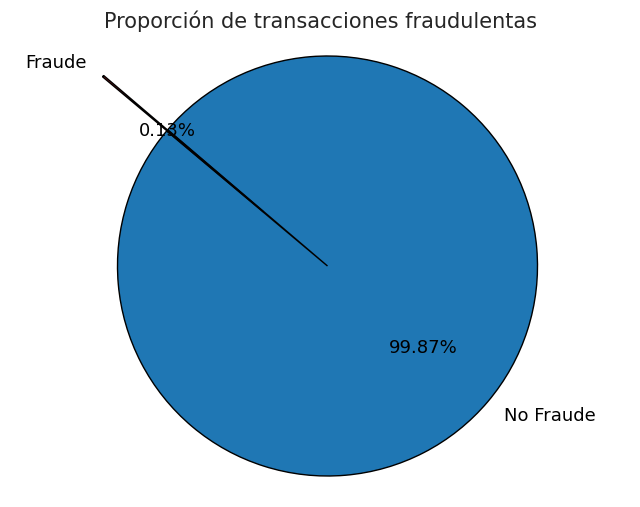

In [37]:
# Distribución de clases
fraud_count = df["isFraud"].value_counts()
print("Distribución de clases:\n", fraud_count)
print("Proporción de fraudes: {:.4f}%".format((fraud_count[1] / fraud_count.sum()) * 100))

# Definir tamaños y etiquetas
sizes = [fraud_count[0], fraud_count[1]]
labels = ['No Fraude', 'Fraude']

# Colores bien contrastantes
colors = ['#1f77b4', '#d62728']  # azul y rojo
explode = (0, 0.4)  # Separar el fraude visualmente

# Graficar
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.2f%%',
    shadow=False,
    startangle=140,
    textprops={'fontsize': 13, 'color': 'black'}
)

# Añadir borde para mejor visualización del fraude
for w in wedges:
    w.set_edgecolor('black')

plt.title("Proporción de transacciones fraudulentas", fontsize=15)
plt.axis('equal')
plt.show()


Tipos de transacción:
 type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


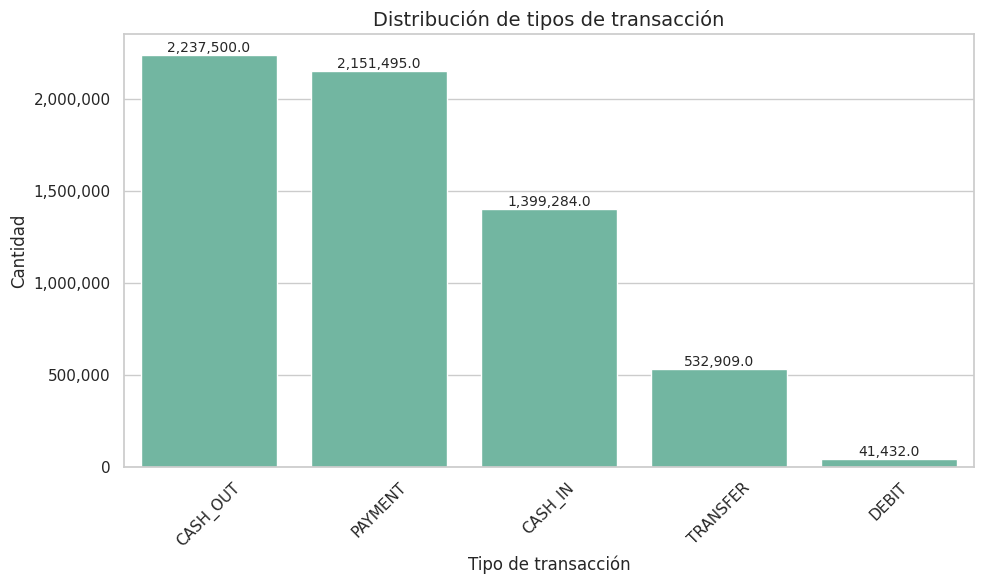

In [38]:
import matplotlib.ticker as mtick

tipo_transacciones = df['type'].value_counts()
print("Tipos de transacción:\n", tipo_transacciones)

sns.set_palette("Set2")
ax = sns.countplot(data=df, x="type", order=tipo_transacciones.index)
plt.title("Distribución de tipos de transacción", fontsize=14)
plt.xlabel("Tipo de transacción")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)

# Mostrar números enteros con separador de miles en el eje Y
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Etiquetas arriba de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



Proporción de fraudes por tipo de transacción:
 type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


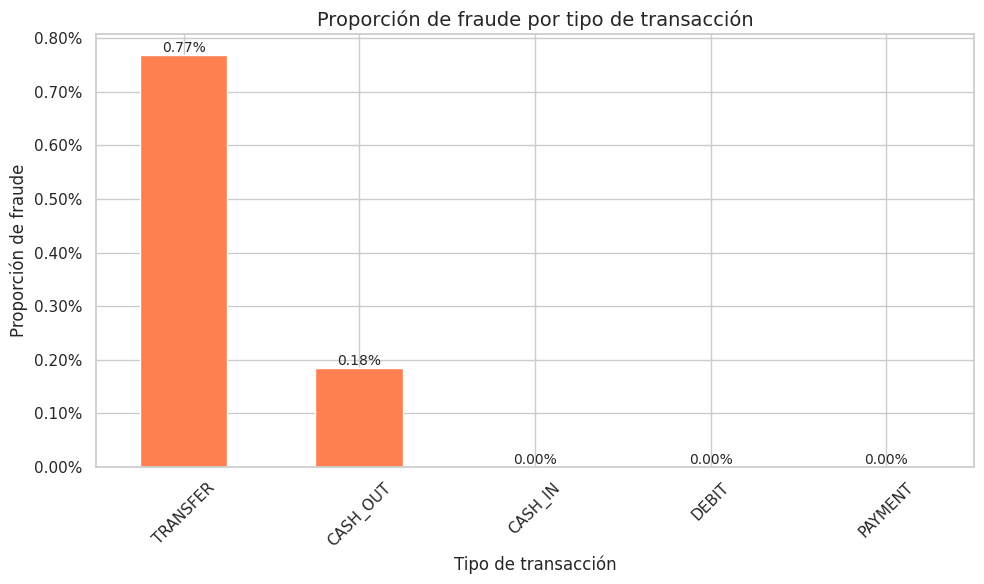

In [39]:
import matplotlib.ticker as mtick

# Calcular proporción de fraude por tipo de transacción
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
print("Proporción de fraudes por tipo de transacción:\n", fraud_by_type)

# Crear gráfico de barras con colores y etiquetas
plt.figure(figsize=(10,6))
ax = fraud_by_type.plot(kind="bar", color="coral")

plt.title("Proporción de fraude por tipo de transacción", fontsize=14)
plt.ylabel("Proporción de fraude")
plt.xlabel("Tipo de transacción")
plt.xticks(rotation=45)

# Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Agregar etiquetas con porcentaje encima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [14]:
# Inconsistencias en balances
df["diff_balanceOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]
df["diff_balanceDest"] = df["newbalanceDest"] - df["oldbalanceDest"] - df["amount"]

print("\nDiferencias en balances (origen):")
print(df[df["diff_balanceOrig"] != 0][["amount", "oldbalanceOrg", "newbalanceOrig", "diff_balanceOrig"]].head())

print("\nDiferencias en balances (destino):")
print(df[df["diff_balanceDest"] != 0][["amount", "oldbalanceDest", "newbalanceDest", "diff_balanceDest"]].head())



Diferencias en balances (origen):
    amount  oldbalanceOrg  newbalanceOrig  diff_balanceOrig
0  9839.64      170136.00       160296.36      1.455192e-11
1  1864.28       21249.00        19384.72     -1.136868e-12
5  7817.71       53860.00        46042.29     -9.094947e-13
6  7107.77      183195.00       176087.23     -1.091394e-11
7  7861.64      176087.23       168225.59      1.364242e-11

Diferencias en balances (destino):
     amount  oldbalanceDest  newbalanceDest  diff_balanceDest
0   9839.64             0.0             0.0          -9839.64
1   1864.28             0.0             0.0          -1864.28
2    181.00             0.0             0.0           -181.00
3    181.00         21182.0             0.0         -21363.00
4  11668.14             0.0             0.0         -11668.14


<ipython-input-15-35401c837923>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = fraud_df.groupby(['amount_range', 'type']).size().reset_index(name='count')


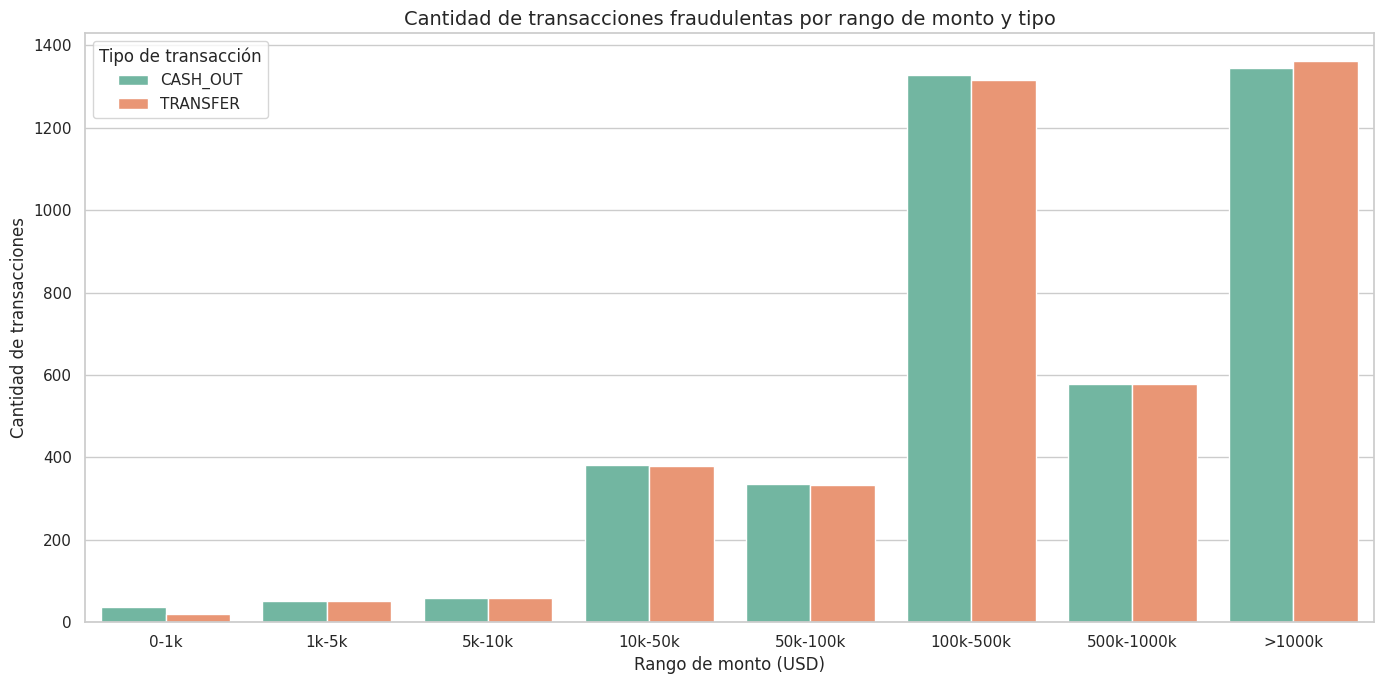

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo transacciones fraudulentas
fraud_df = df[df['isFraud'] == 1].copy()

# Definir rangos de montos más amplios y detallados
bins = [0, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, fraud_df['amount'].max()]
labels = ['0-1k', '1k-5k', '5k-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1000k', '>1000k']

# Crear columna de rangos
fraud_df['amount_range'] = pd.cut(fraud_df['amount'], bins=bins, labels=labels, include_lowest=True)

# Agrupar datos por rango y tipo
grouped = fraud_df.groupby(['amount_range', 'type']).size().reset_index(name='count')

# Crear gráfico
plt.figure(figsize=(14, 7))
sns.barplot(data=grouped, x='amount_range', y='count', hue='type', palette='Set2')

plt.title('Cantidad de transacciones fraudulentas por rango de monto y tipo', fontsize=14)
plt.xlabel('Rango de monto (USD)')
plt.ylabel('Cantidad de transacciones')
plt.legend(title='Tipo de transacción')
plt.tight_layout()
plt.show()


# 2) Creación de columnas adicionales

In [40]:
import numpy as np

# 1. Diferencias de saldo (inconsistencias)
df['delta_origin'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['delta_dest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

# 2. Indicadores de saldo cero
df['org_balance_is_zero'] = (df['oldbalanceOrg'] == 0).astype(int)
df['dest_balance_is_zero'] = (df['oldbalanceDest'] == 0).astype(int)

# 3. Monto igual al saldo inicial (sospechoso)
df['amount_equals_balance'] = (df['amount'] == df['oldbalanceOrg']).astype(int)

# 4. Transformación logarítmica del monto
df['log_amount'] = np.log1p(df['amount'])

# 5. Hora y día simulados (step: cada unidad es una hora)
df['day'] = df['step'] // 24
df['hour'] = df['step'] % 24

# 6. Detección de outliers en 'amount' (sin eliminarlos)
q1 = df['amount'].quantile(0.25)
q3 = df['amount'].quantile(0.75)
iqr = q3 - q1
df['is_outlier_amount'] = ((df['amount'] < (q1 - 1.5 * iqr)) | (df['amount'] > (q3 + 1.5 * iqr))).astype(int)

print("Transformaciones completadas. Nuevas columnas creadas:")
print(['delta_origin', 'delta_dest', 'org_balance_is_zero', 'dest_balance_is_zero',
       'amount_equals_balance', 'log_amount', 'day', 'hour', 'is_outlier_amount'])


Transformaciones completadas. Nuevas columnas creadas:
['delta_origin', 'delta_dest', 'org_balance_is_zero', 'dest_balance_is_zero', 'amount_equals_balance', 'log_amount', 'day', 'hour', 'is_outlier_amount']


<ipython-input-41-92216ca752f7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fraudes, x='hour', palette='viridis')


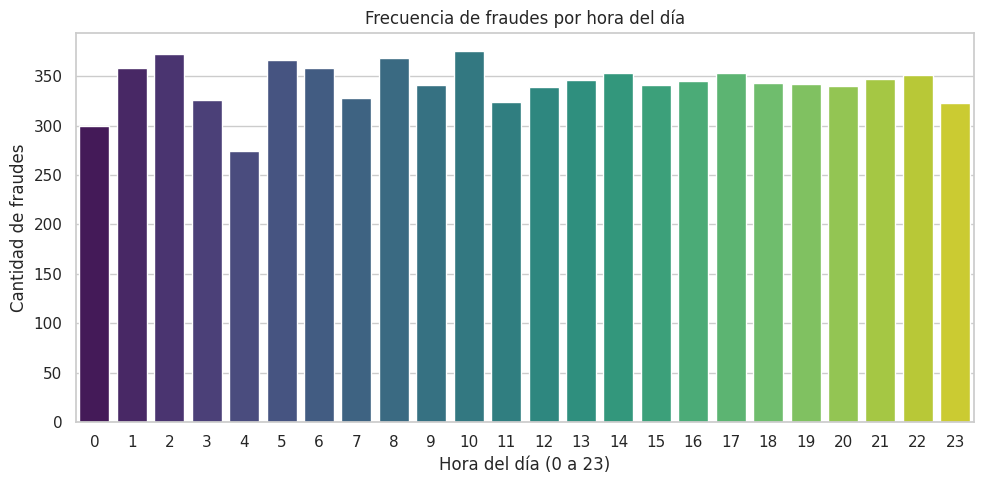

In [41]:
# Asegurate de tener la columna 'hour' (si no la tenés, creala con):
df['hour'] = df['step'] % 24

# Filtrar solo los fraudes
fraudes = df[df['isFraud'] == 1]

# Gráfico por hora
plt.figure(figsize=(10, 5))
sns.countplot(data=fraudes, x='hour', palette='viridis')
plt.title('Frecuencia de fraudes por hora del día')
plt.xlabel('Hora del día (0 a 23)')
plt.ylabel('Cantidad de fraudes')
plt.tight_layout()
plt.show()


# Aplicacion de modelos

## Random Forest

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preparación de datos ---

# Lista de features base + transformadas
features = [
    'amount', 'log_amount',
    'delta_origin', 'delta_dest',
    'org_balance_is_zero', 'dest_balance_is_zero',
    'amount_equals_balance',
    'day', 'hour', 'is_outlier_amount'
]

# Crear copia para no modificar original
df_model = df.copy()

# Convertir variable categórica 'type' a variables dummy
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

# Agregar columnas dummy de 'type' a features
features += [col for col in df_model.columns if col.startswith('type_')]

# Definir X, y
X = df_model[features]
y = df_model['isFraud']

# División train-test estratificada para mantener proporción de fraudes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

Accuracy: 1.0000
Precision: 1.0000
Recall: 0.9976
F1-Score: 0.9988
AUC-ROC: 0.9988
Matriz de confusión:
[[1270881       0]
 [      4    1639]]


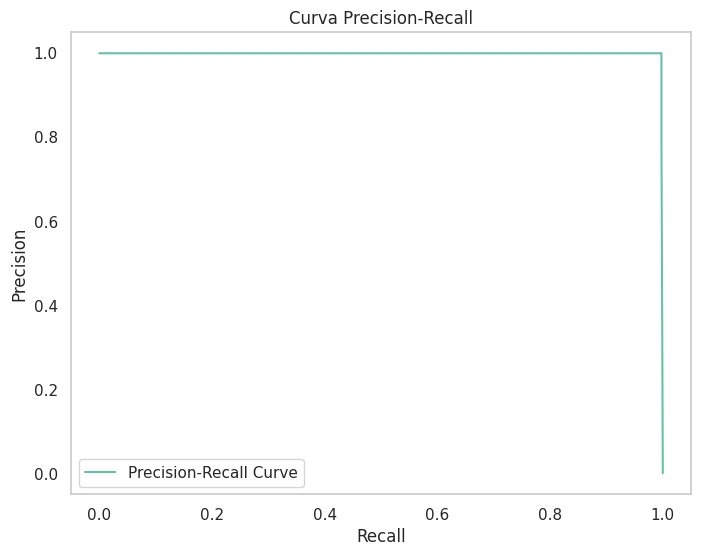

In [19]:
# --- Entrenamiento del modelo ---

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Manejo automático del desbalance
)
model.fit(X_train, y_train)

# --- Predicciones ---

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# --- Métricas ---

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Matriz de confusión:")
print(cm)

# --- Curva Precision-Recall ---

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()


Importancia de variables:

<ipython-input-20-987f119b6c9f>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')


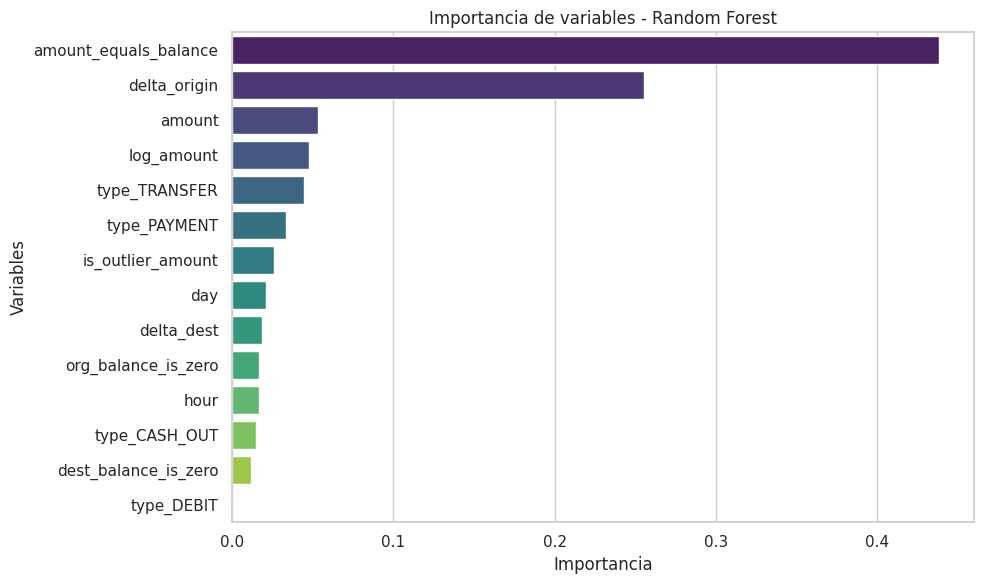

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener importancia de variables
importances = model.feature_importances_

# Crear DataFrame para visualizar
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Ordenar por importancia descendente
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')
plt.title('Importancia de variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


## XGBoost

Accuracy XGBoost: 1.0000
Precision XGBoost: 0.9862
Recall XGBoost: 0.9976
F1-Score XGBoost: 0.9918
AUC-ROC XGBoost: 0.9997
Matriz de confusión XGBoost:
[[1270858      23]
 [      4    1639]]


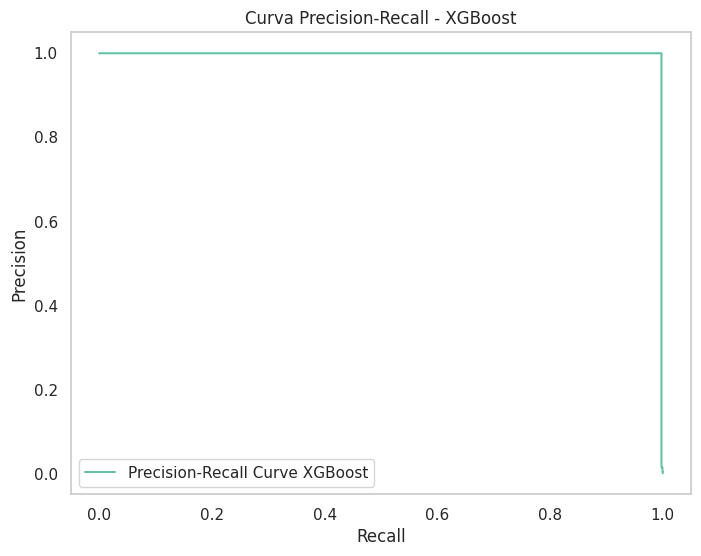

In [43]:
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve)

# Preparar DMatrix para XGBoost (opcional, pero recomendado)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir parámetros base (ajustables)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # balancea clases
    'seed': 42,
    'verbosity': 1
}

# Entrenar modelo
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predecir probabilidades y etiquetas
y_proba_xgb = bst.predict(dtest)
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Métricas
acc_2 = accuracy_score(y_test, y_pred_xgb)
prec_2 = precision_score(y_test, y_pred_xgb)
rec_2 = recall_score(y_test, y_pred_xgb)
f1_2 = f1_score(y_test, y_pred_xgb)
auc_2 = roc_auc_score(y_test, y_proba_xgb)
cm_2 = confusion_matrix(y_test, y_pred_xgb)

print(f"Accuracy XGBoost: {acc_2:.4f}")
print(f"Precision XGBoost: {prec_2:.4f}")
print(f"Recall XGBoost: {rec_2:.4f}")
print(f"F1-Score XGBoost: {f1_2:.4f}")
print(f"AUC-ROC XGBoost: {auc_2:.4f}")
print("Matriz de confusión XGBoost:")
print(cm_2)

# Curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label='Precision-Recall Curve XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - XGBoost')
plt.legend()
plt.grid()
plt.show()


Importancia de variablees:

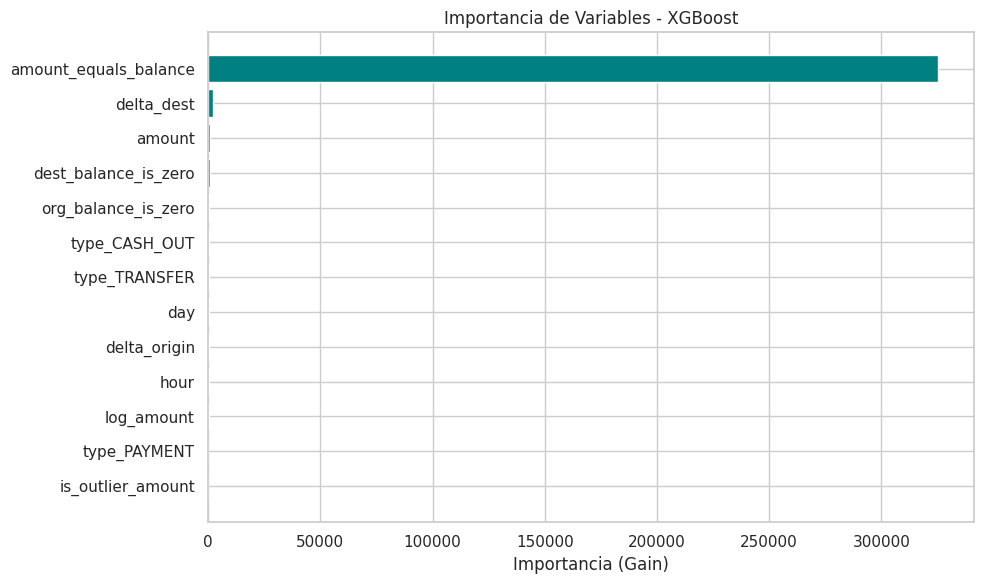

In [44]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Obtener importancia de variables (gain es lo más interpretativo)
importance = bst.get_score(importance_type='gain')

# Convertir a DataFrame para ordenar y graficar
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'], color='teal')
plt.gca().invert_yaxis()
plt.xlabel('Importancia (Gain)')
plt.title('Importancia de Variables - XGBoost')
plt.tight_layout()
plt.show()


## LGBM

[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy LightGBM: 1.0000
Precision LightGBM: 0.9715
Recall LightGBM: 0.9976
F1-Score LightGBM: 0.9844
AUC-ROC LightGBM: 0.9998
Matriz de confusión LightGBM:
[[1270833      48]
 [      4    1639]]


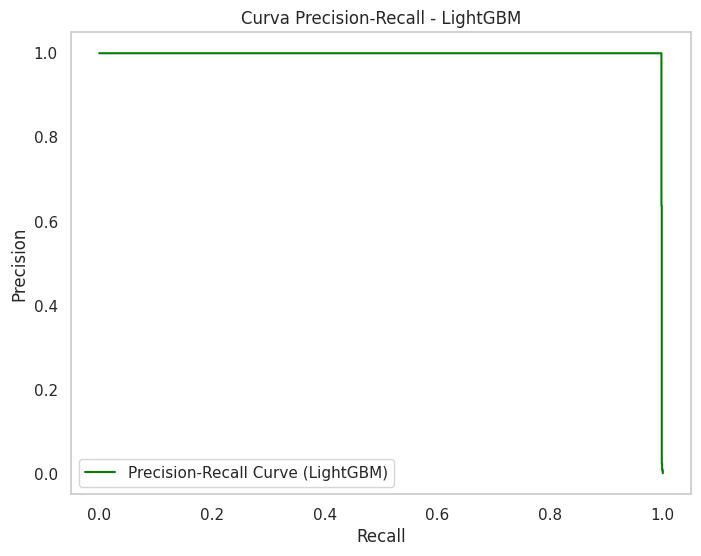

In [23]:
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve)
import matplotlib.pyplot as plt

# Crear el modelo con balanceo
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    class_weight='balanced',  # Para manejar desbalance
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
lgbm_model.fit(X_train, y_train)

# Predicciones
y_pred_lgb = lgbm_model.predict(X_test)
y_proba_lgb = lgbm_model.predict_proba(X_test)[:, 1]

# Métricas
acc_3 = accuracy_score(y_test, y_pred_lgb)
prec_3 = precision_score(y_test, y_pred_lgb)
rec_3 = recall_score(y_test, y_pred_lgb)
f1_3 = f1_score(y_test, y_pred_lgb)
auc_3 = roc_auc_score(y_test, y_proba_lgb)
cm_3 = confusion_matrix(y_test, y_pred_lgb)

print(f"Accuracy LightGBM: {acc_3:.4f}")
print(f"Precision LightGBM: {prec_3:.4f}")
print(f"Recall LightGBM: {rec_3:.4f}")
print(f"F1-Score LightGBM: {f1_3:.4f}")
print(f"AUC-ROC LightGBM: {auc_3:.4f}")
print("Matriz de confusión LightGBM:")
print(cm_3)

# Curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_lgb)

plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label='Precision-Recall Curve (LightGBM)', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - LightGBM')
plt.legend()
plt.grid()
plt.show()


Importancia de variables

<ipython-input-24-5cc1344f3090>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lgbm_importances.head(20), x='importance', y='feature', palette='Blues_r')


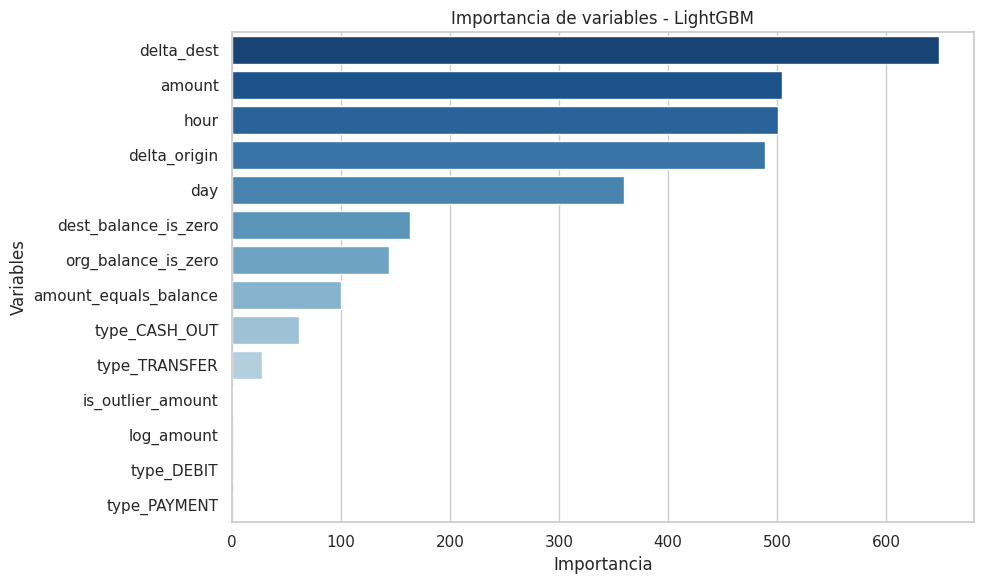

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener importancia
lgbm_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_model.feature_importances_
})

# Ordenar y graficar
lgbm_importances = lgbm_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=lgbm_importances.head(20), x='importance', y='feature', palette='Blues_r')
plt.title('Importancia de variables - LightGBM')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


## Ensamblados

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.136803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy Ensemble: 1.0000
Precision Ensemble: 1.0000
Recall Ensemble: 0.9976
F1-Score Ensemble: 0.9988
AUC-ROC Ensemble: 0.9998
Matriz de confusión Ensemble:
[[1270881       0]
 [      4    1639]]


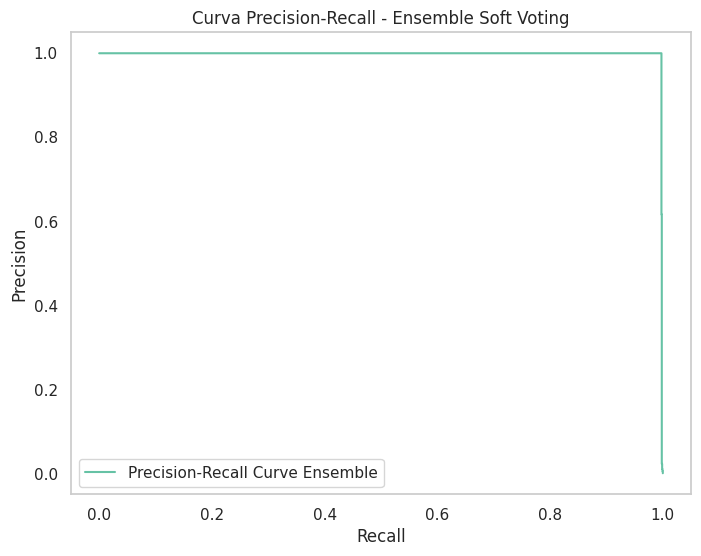

In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

# Reentrenar XGBoost y LightGBM con scikit-learn API para integrarlos
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

lgbm_clf = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Crear ensemble con soft voting
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf)],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)

# Predecir
y_pred_ensemble = voting_clf.predict(X_test)
y_proba_ensemble = voting_clf.predict_proba(X_test)[:, 1]

# Calcular métricas
acc_4 = accuracy_score(y_test, y_pred_ensemble)
prec_4 = precision_score(y_test, y_pred_ensemble)
rec_4 = recall_score(y_test, y_pred_ensemble)
f1_4 = f1_score(y_test, y_pred_ensemble)
auc_4 = roc_auc_score(y_test, y_proba_ensemble)
cm_4 = confusion_matrix(y_test, y_pred_ensemble)

print(f"Accuracy Ensemble: {acc_4:.4f}")
print(f"Precision Ensemble: {prec_4:.4f}")
print(f"Recall Ensemble: {rec_4:.4f}")
print(f"F1-Score Ensemble: {f1_4:.4f}")
print(f"AUC-ROC Ensemble: {auc_4:.4f}")
print("Matriz de confusión Ensemble:")
print(cm_4)

# Curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_ensemble)

plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label='Precision-Recall Curve Ensemble')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Ensemble Soft Voting')
plt.legend()
plt.grid()
plt.show()


### Tabla comparativa

In [58]:
# Crear tabla con las métricas de los tres modelos
resultados = {
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],

    'Random Forest': [acc, prec, rec, f1, auc],
    'XGBoost':        [acc_2, prec_2, rec_2, f1_2, auc_2],
    'LightGBM':       [acc_3, prec_3, rec_3, f1_3, auc_3],
    'Ensamble':       [acc_4, prec_4, rec_4, f1_4, auc_4]
}

# Convertir a DataFrame
tabla_comparativa = pd.DataFrame(resultados)

# Mostrar tabla
print("Comparación de métricas entre modelos:")
display(tabla_comparativa)


Comparación de métricas entre modelos:


,Métrica,Random Forest,XGBoost,LightGBM,Ensamble
0,Accuracy,0.999997,0.999979,0.999959,0.999997
1,Precision,1.000000,0.986161,0.971547,1.000000
2,Recall,0.997565,0.997565,0.997565,0.997565
3,F1-Score,0.998781,0.991831,0.984384,0.998781
4,AUC-ROC,0.998782,0.999685,0.999774,0.999770


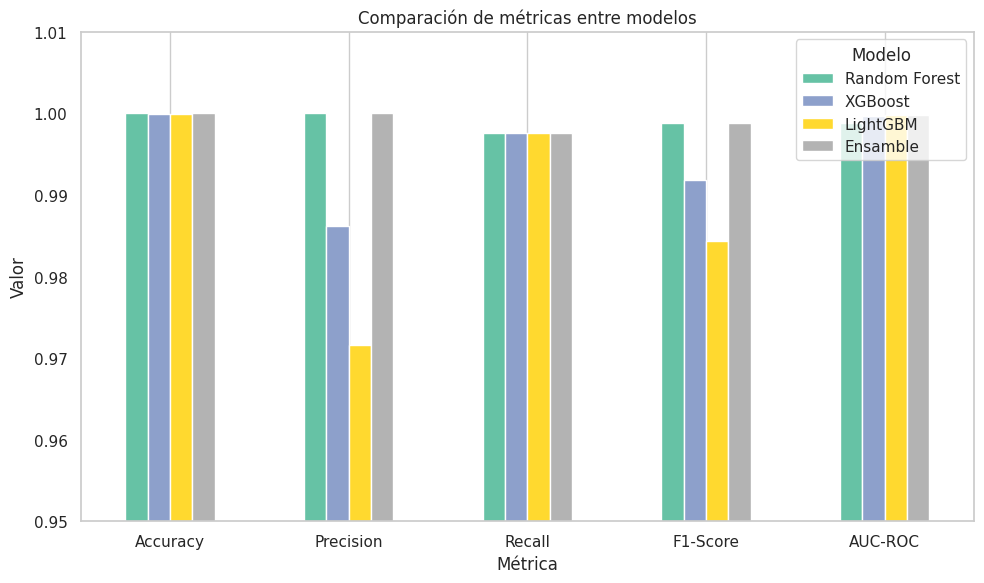

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear DataFrame con tus variables
df_metricas = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Random Forest': [acc, prec, rec, f1, auc],
    'XGBoost': [acc_2, prec_2, rec_2, f1_2, auc_2],
    'LightGBM': [acc_3, prec_3, rec_3, f1_3, auc_3],
    'Ensamble': [acc_4, prec_4, rec_4, f1_4, auc_4]
})

# Graficar
df_metricas.set_index('Métrica').plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title('Comparación de métricas entre modelos')
plt.ylabel('Valor')
plt.ylim(0.95, 1.01)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()


| Métrica   | Mejor modelo      | Comentario                                                       |
| --------- | ----------------- | ---------------------------------------------------------------- |
| Accuracy  | **Random Forest** | Gana por poco, pero todos tienen excelente precisión global.     |
| Precision | **Random Forest** | Detecta fraudes sin muchos falsos positivos (100% de precisión). |
| Recall    | **Empate**        | Todos detectan el 99.75% de los fraudes: excelente sensibilidad. |
| F1-Score  | **Random Forest** | Mejor balance entre precisión y recall.                          |
| AUC-ROC   | **LightGBM**      | Mejor capacidad para discriminar clases con probabilidades.      |


# Usar Isolation Forest para la clasificación de Fraude

In [46]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

# Seleccionar las mismas features usadas en modelos supervisados
X_iso = df_model[features]  # df_model ya tiene dummies

# Entrenar Isolation Forest (sin usar y)
iso_model = IsolationForest(contamination=0.005, random_state=42)  # contamination ≈ % de fraudes
iso_model.fit(X_iso)

# Predecir: -1 = anomalía, 1 = normal
y_pred_iso = iso_model.predict(X_iso)

# Convertir a 0/1 para comparar con isFraud
y_pred_iso = (y_pred_iso == -1).astype(int)  # anomalía = 1 (fraude predicho)

# y_true real
y_true = df_model['isFraud']

# Métricas
print("Matriz de confusión (Isolation Forest vs isFraud):")
print(confusion_matrix(y_true, y_pred_iso))
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred_iso))


Matriz de confusión (Isolation Forest vs isFraud):
[[6324222   30185]
 [   6584    1629]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.05      0.20      0.08      8213

    accuracy                           0.99   6362620
   macro avg       0.53      0.60      0.54   6362620
weighted avg       1.00      0.99      1.00   6362620



In [30]:
# Total de transacciones predichas como fraude (anomalía)
predicciones_fraude = (y_pred_iso == 1).sum()
total_transacciones = len(y_pred_iso)

print("Transacciones marcadas como fraude por Isolation Forest:", predicciones_fraude)
print("Total de transacciones:", total_transacciones)
print("Porcentaje predicho como fraude: {:.4f}%".format((predicciones_fraude / total_transacciones) * 100))

# Comparar predicciones de fraude con etiquetas reales
fraudes_reales = y_true.sum()
fraudes_detectados = ((y_pred_iso == 1) & (y_true == 1)).sum()

print("Fraudes reales en el dataset:", fraudes_reales)
print("Fraudes detectados correctamente por Isolation Forest:", fraudes_detectados)
print("Recall (sensibilidad): {:.4f}%".format((fraudes_detectados / fraudes_reales) * 100))

# Precisión: de todos los que marcó como fraude, ¿cuántos eran realmente fraude?
falsos_positivos = ((y_pred_iso == 1) & (y_true == 0)).sum()
precision_iso = fraudes_detectados / (fraudes_detectados + falsos_positivos)

print("Falsos positivos (no fraude marcados como fraude):", falsos_positivos)
print("Precisión de Isolation Forest: {:.4f}%".format(precision_iso * 100))


Transacciones marcadas como fraude por Isolation Forest: 31814
Total de transacciones: 6362620
Porcentaje predicho como fraude: 0.5000%
Fraudes reales en el dataset: 8213
Fraudes detectados correctamente por Isolation Forest: 1629
Recall (sensibilidad): 19.8344%
Falsos positivos (no fraude marcados como fraude): 30185
Precisión de Isolation Forest: 5.1204%
